## Import data

**Business Problem**: Tingginya tingkat churn pelanggan di perusahaan telekomunikasi menimbulkan kerugian finansial karena hilangnya pelanggan dan pendapatan berulang. Mempertahankan pelanggan yang sudah ada lebih hemat biaya dibandingkan dengan menarik pelanggan baru. Oleh karena itu, penting untuk memahami faktor-faktor yang memengaruhi churn sehingga perusahaan dapat mengambil tindakan pencegahan untuk mempertahankan pelanggan.

**Stakeholder**: 
- **Tim Retensi dan Pemasaran**: Bertanggung jawab dalam upaya mempertahankan pelanggan yang berisiko churn.
- **Tim Manajemen**: Membutuhkan model prediksi untuk pengambilan keputusan strategis yang berbasis data guna menurunkan churn rate dan menjaga stabilitas pendapatan.

**Tujuan Bisnis**:
- **Mengidentifikasi pelanggan yang berisiko churn** sehingga perusahaan dapat mengambil tindakan preventif untuk mempertahankan mereka.
- **Meningkatkan tingkat retensi pelanggan** yang pada akhirnya akan membantu perusahaan menjaga stabilitas pendapatan dan mengurangi biaya terkait churn.

### Pemahaman Data untuk Dataset Telco Customer Churn

#### Gambaran Data:
- **Total Data**: 4.930 entri, tanpa nilai yang hilang.
- **Kolom**:
  - **Kolom Numerik**:
    - `tenure`: Tipe integer yang menunjukkan jumlah bulan pelanggan berlangganan. Rentang dari 0 hingga 72 bulan dengan rata-rata sekitar 32 bulan.
    - `MonthlyCharges`: Tipe float yang menunjukkan biaya layanan bulanan. Rentang dari 18,8 hingga 118,65 dengan rata-rata sekitar 64,88.
  - **Kolom Kategorikal**:
    - **Kategori Biner**: `Dependents`, `PaperlessBilling`, `Churn`
      - Contoh: `Churn` memiliki dua nilai, yaitu Yes (menandakan pelanggan berhenti) dan No (pelanggan tidak berhenti).
    - **Layanan Terkait**:
      - `OnlineSecurity`, `OnlineBackup`, `InternetService`, `DeviceProtection`, `TechSupport`
      - Kategori seperti `'No internet service'` menunjukkan pelanggan yang tidak berlangganan layanan tertentu.
    - **Tipe Kontrak**:
      - `Contract` dengan tiga tipe: `Month-to-month`, `One year`, dan `Two year`.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('data_telco_customer_churn.csv')
data.head()


,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


## Data Preprocessing

### Check Missing Values

In [3]:
# Step 1: Check Missing Values
missing_values = data.isnull().sum()
missing_values


Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

### Checking Data Duplicate

In [4]:
# Step 2: Check Duplicates
duplicate_count = data.duplicated().sum()
print('Data Duplikasi: ', duplicate_count)

# Step 3: Drop data Duplicate
data_cleaned = data.drop_duplicates()
print('After Cleaning Data: ', data_cleaned.duplicated().sum())

Data Duplikasi:  77
After Cleaning Data:  0


### Checking Data Outlier

In [5]:
# Step 4: Check for outliers (using IQR method for numerical columns)
numerical_cols = ['tenure', 'MonthlyCharges']
for col in numerical_cols:
    q1 = data_cleaned[col].quantile(0.25)
    q3 = data_cleaned[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data_cleaned[(data_cleaned[col] < lower_bound) | (data_cleaned[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers detected.")

tenure: 0 outliers detected.
MonthlyCharges: 0 outliers detected.


### Encoding

In [6]:
# Step 5: Encode categorical columns

# Categorical columns
categorical_cols = ['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 
                    'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'Churn']

# Reinitialize label encoders
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col])
    label_encoders[col] = le

# Prepare summary again
encoding_summary = {}
for col in categorical_cols:
    original_values = list(label_encoders[col].classes_)
    encoded_values = list(range(len(original_values)))
    mapping = dict(zip(original_values, encoded_values))
    encoding_summary[col] = {
        "Original Values": original_values,
        "Encoded Values": encoded_values,
        "Detail": mapping
    }

encoding_summary


{'Dependents': {'Original Values': ['No', 'Yes'],
  'Encoded Values': [0, 1],
  'Detail': {'No': 0, 'Yes': 1}},
 'OnlineSecurity': {'Original Values': ['No', 'No internet service', 'Yes'],
  'Encoded Values': [0, 1, 2],
  'Detail': {'No': 0, 'No internet service': 1, 'Yes': 2}},
 'OnlineBackup': {'Original Values': ['No', 'No internet service', 'Yes'],
  'Encoded Values': [0, 1, 2],
  'Detail': {'No': 0, 'No internet service': 1, 'Yes': 2}},
 'InternetService': {'Original Values': ['DSL', 'Fiber optic', 'No'],
  'Encoded Values': [0, 1, 2],
  'Detail': {'DSL': 0, 'Fiber optic': 1, 'No': 2}},
 'DeviceProtection': {'Original Values': ['No', 'No internet service', 'Yes'],
  'Encoded Values': [0, 1, 2],
  'Detail': {'No': 0, 'No internet service': 1, 'Yes': 2}},
 'TechSupport': {'Original Values': ['No', 'No internet service', 'Yes'],
  'Encoded Values': [0, 1, 2],
  'Detail': {'No': 0, 'No internet service': 1, 'Yes': 2}},
 'Contract': {'Original Values': ['Month-to-month', 'One year', 'T

### Visualiasi

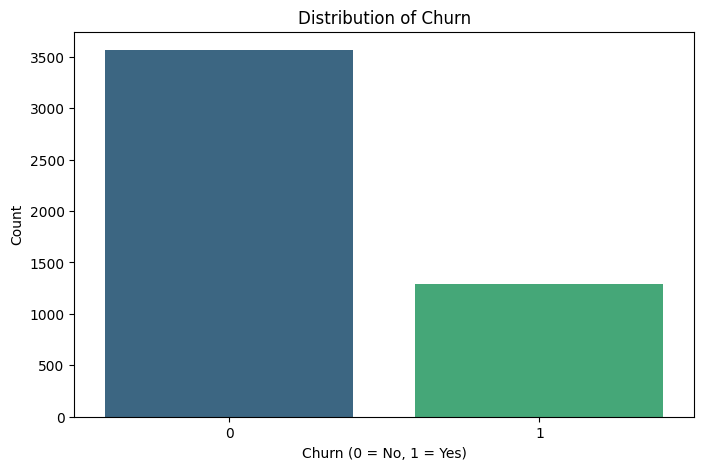

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Visualize the distribution of the target variable (Churn)
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=data_cleaned, palette='viridis')
plt.title('Distribution of Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

Pelanggan yang tidak churn (label 0) jauh lebih banyak dibandingkan pelanggan yang churn (label 1).

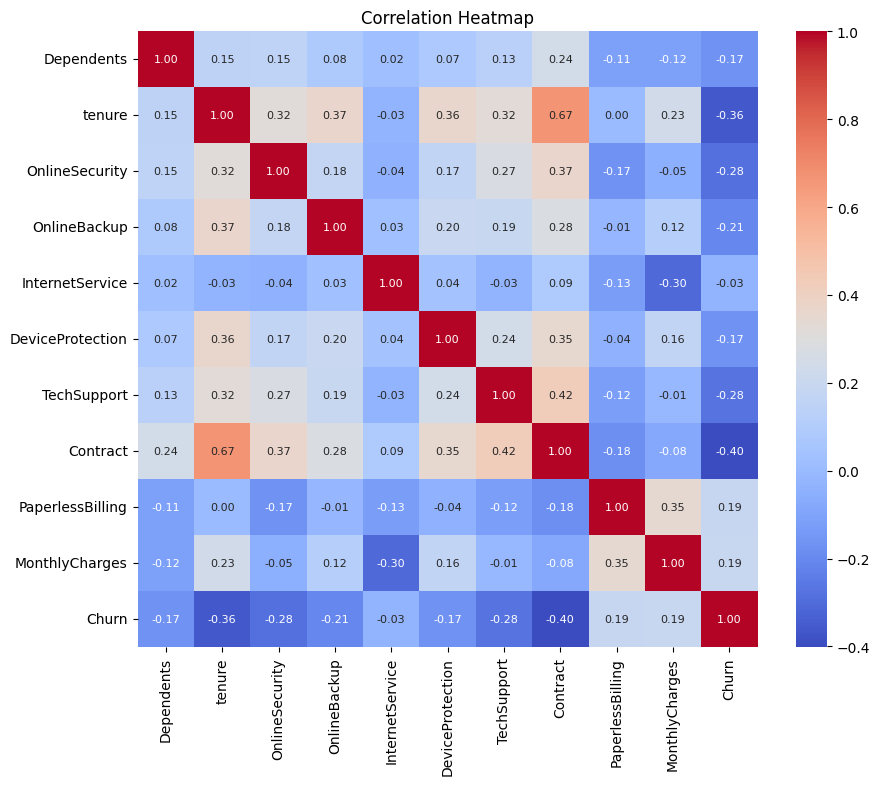

In [8]:
# Step 2: Correlation heatmap for features and target
plt.figure(figsize=(10, 8))
correlation_matrix = data_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, annot_kws={"size":8})
plt.title('Correlation Heatmap')
plt.show()

1. Korelasi kuat antara fitur seperti Contract (jenis kontrak) dan Churn.

2. Fitur tenure (lama berlangganan) memiliki korelasi negatif dengan churn, artinya pelanggan yang telah berlangganan lebih lama cenderung tidak churn.

3. Fitur terkait layanan internet seperti OnlineSecurity, OnlineBackup, dan TechSupport juga memiliki korelasi yang signifikan.

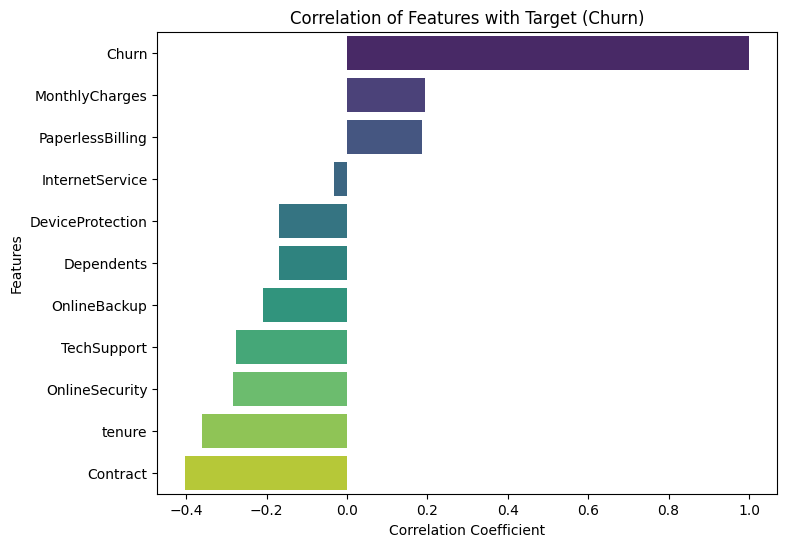

In [9]:
# Step 3: Correlation with target (Churn)
target_corr = correlation_matrix['Churn'].sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')
plt.title('Correlation of Features with Target (Churn)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()


1. Contract memiliki korelasi negatif yang kuat, menunjukkan bahwa pelanggan dengan kontrak lebih lama cenderung tidak churn.

2. tenure juga memiliki korelasi negatif yang signifikan.
MonthlyCharges memiliki korelasi positif moderat, menunjukkan bahwa pelanggan dengan biaya bulanan lebih tinggi sedikit lebih mungkin churn.

3. Fitur-fitur terkait keamanan, backup, dan dukungan teknis menunjukkan korelasi negatif yang lebih lemah.


## Model dan Metrics

### Penjelasan Metrics:
1. **Accuracy**: Persentase prediksi yang benar secara keseluruhan.
2. **Precision**: Proporsi prediksi positif yang benar.
3. **Recall**: Proporsi kelas positif yang terprediksi dengan benar.
4. **F1-Score**: Rata-rata harmonis dari precision dan recall.
5. **ROC AUC**: Mengukur kemampuan model membedakan antara kelas positif dan negatif.

### Evaluasi:
- Memahami kinerja model secara keseluruhan.
- Menentukan seberapa baik model mendeteksi churn.
- Memvisualisasikan performa model menggunakan ROC Curve.


                 Model  Accuracy  F1-Score   ROC-AUC
0  Logistic Regression  0.795057  0.584551  0.842738
1        Decision Tree  0.721936  0.464286  0.638690
2        Random Forest  0.762101  0.494530  0.792568
3    Gradient Boosting  0.788877  0.533030  0.835486
4                  SVM  0.791967  0.482051  0.789920
5                  KNN  0.764161  0.533605  0.774957

Evaluasi Model Terbaik:
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       713
           1       0.63      0.54      0.58       258

    accuracy                           0.80       971
   macro avg       0.74      0.71      0.72       971
weighted avg       0.79      0.80      0.79       971

Confusion Matrix:
[[632  81]
 [118 140]]
ROC AUC: 0.84


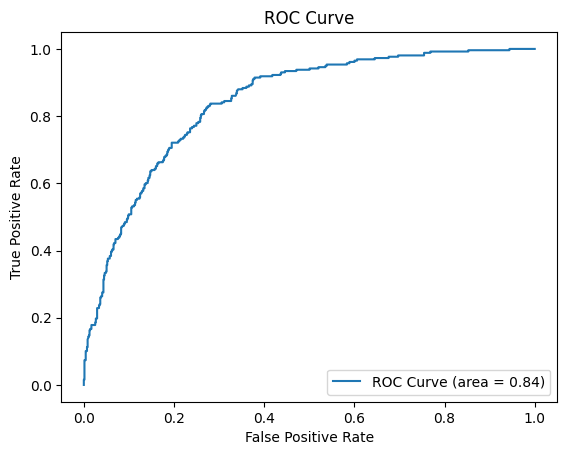

Churn Retention Metric: 0.61


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split data
X = data_cleaned.drop('Churn', axis=1)
y = data_cleaned['Churn']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

# Store evaluation results
results = []
best_model = None
best_auc = 0

for model_name, model in models.items():
    model.fit(X_train, y_train)  # Training
    y_pred = model.predict(X_val)  # Prediction
    y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob) if y_prob is not None else None
    
    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "F1-Score": f1,
        "ROC-AUC": auc
    })
    
    # Keep track of the best model (based on ROC-AUC)
    if auc and auc > best_auc:
        best_model = model
        best_auc = auc

# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Evaluate the best model
print("\nEvaluasi Model Terbaik:")
y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# ROC AUC
roc_auc = roc_auc_score(y_val, y_prob)
print(f"ROC AUC: {roc_auc:.2f}")

# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Custom Metric: Churn Retention Metric
def churn_retention_metric(y_true, y_pred, retention_weight=0.7):
    from sklearn.metrics import precision_score, recall_score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    retention_metric = retention_weight * precision + (1 - retention_weight) * recall
    return retention_metric

retention_score = churn_retention_metric(y_val, y_pred)
print(f"Churn Retention Metric: {retention_score:.2f}")


## Hasil Evaluasi
- Model *Logistic Regression* memiliki nilai *ROC-AUC tertinggi* (0.842738), yang menunjukkan performa terbaik dalam membedakan kelas positif dan negatif.
- Model *Decision Tree* memiliki performa terendah berdasarkan F1-Score (0.453649) dan ROC-AUC (0.632843).
- Untuk data ini, *Logistic Regression* adalah pilihan terbaik berdasarkan evaluasi keseluruhan (ROC-AUC dan Accuracy).

---

### Evaluasi Model Terbaik
Model terbaik, *Logistic Regression*, telah dievaluasi lebih lanjut menggunakan beberapa metrik tambahan.

1. *Precision*:
   - *Kelas 0*: Dari semua prediksi "tidak churn," 84% benar.
   - *Kelas 1*: Dari semua prediksi "churn," 63% benar.

2. *Recall*:
   - *Kelas 0*: Dari semua pelanggan "tidak churn," 89% berhasil terdeteksi.
   - *Kelas 1*: Dari semua pelanggan "churn," 54% berhasil terdeteksi.

3. *F1-Score*:
   - Rata-rata harmonis antara precision dan recall.
   - *Kelas 1* memiliki F1-Score yang lebih rendah (0.58), yang menunjukkan model kesulitan mendeteksi churn.

4. *Support*:
   - Banyaknya data aktual pada masing-masing kelas: 713 untuk "tidak churn" dan 258 untuk "churn."

5. *Accuracy*: Model memiliki akurasi 80% secara keseluruhan.

### Confusion Matrix

1. *True Positives (TP):* 140 pelanggan churn yang berhasil terdeteksi.
2. *True Negatives (TN):* 632 pelanggan tidak churn yang terdeteksi dengan benar.
3. *False Positives (FP):* 81 pelanggan tidak churn tetapi diprediksi sebagai churn.
4. *False Negatives (FN):* 118 pelanggan churn tetapi diprediksi sebagai tidak churn.

#### Implikasi Bisnis:
- *False Negatives (118)*: Pelanggan churn yang tidak terdeteksi adalah peluang yang hilang untuk program retensi.
- *False Positives (81)*: Pelanggan tidak churn yang diprediksi churn mungkin menyebabkan alokasi sumber daya yang tidak diperlukan.


### ROC AUC
- *ROC AUC: 0.84* menunjukkan kemampuan model untuk membedakan kelas positif (churn) dan negatif (tidak churn) dengan sangat baik.
- *Kurva ROC* memperlihatkan trade-off antara *True Positive Rate (TPR)* dan *False Positive Rate (FPR)*:
  - Semakin dekat kurva ke sudut kiri atas, semakin baik performa model.

---

### Kesimpulan:
1. Model terbaik berdasarkan *ROC-AUC* adalah *Logistic Regression* dengan nilai 0.84.
2. Model ini memiliki akurasi tinggi (80%), namun kesulitan mendeteksi churn dengan recall 54% untuk kelas churn.
3. *Rekomendasi*:


### Rekomendasi
1. **Strategi Bisnis**:
   - Fokus pada pelanggan dengan kontrak jangka pendek dan tenure rendah, karena mereka memiliki risiko churn yang tinggi.
   - Berikan diskon atau promosi kepada pelanggan dengan biaya bulanan tinggi untuk meningkatkan retensi.

3. **Penggunaan Model Terbaik**:
   - Implementasikan **Logistic Regression** sebagai model utama untuk prediksi churn karena memiliki keseimbangan terbaik antara interpretabilitas dan performa.
   - Fokus pada peningkatan recall untuk kelas churn (misalnya dengan oversampling data churn).
   - Perhatikan false positives untuk menghindari alokasi sumber daya yang tidak diperlukan.

4. **Peningkatan Layanan**:
   - Tingkatkan fitur layanan seperti **OnlineSecurity**, **TechSupport**, dan **OnlineBackup** untuk meningkatkan kepuasan pelanggan.

## Save Model

In [3]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Misalnya Anda menggunakan dataset Iris
data = load_iris()
X = data.data
y = data.target

# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Melatih model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)


model_filename = 'model.pkl'  

# Menyimpan model ke file menggunakan pickle
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model telah disimpan di {model_filename}")


Model telah disimpan di model.pkl
